In [1]:
import sys, os
import numpy as np

from pygama.dsp.ProcessingChain import ProcessingChain
from pygama.dsp.processors import *
from pygama.dsp.units import *

from pygama.io import io_base as io

# CONSTANT VARIABLES TO SET UP CONFIG
filename = os.path.expandvars('$DATADIR/CAGE/pygama_raw/raw_run42.lh5')
groupname = "ORSIS3302DecoderForEnergy"
verbosity = 2
wfblock = 8

In [17]:
# Set up file I/O
lh5 = io.LH5Store()
data = lh5.read_object(groupname, filename, start_row=0, n_rows=1000)

wf_in = data['waveform']['values'].nda
dt = data['waveform']['dt'].nda[0] * unit_parser.parse_unit(data['waveform']['dt'].attrs['units'])

# Set up processing chain
proc = ProcessingChain(block_width=wfblock, clock_unit=dt, verbosity=verbosity)
proc.add_input_buffer("wf", wf_in, dtype='float32')
proc.add_processor(mean_stdev, "wf[0:1000]", "bl", "bl_sig")
proc.add_processor(np.subtract, "wf", "bl", "wf_blsub")
proc.add_processor(pole_zero, "wf_blsub", 70*us, "wf_pz")
proc.add_processor(trap_filter, "wf_pz", 5*us, 10*us, "wf_trap")
proc.add_processor(np.divide, "wf_trap", 10*us, "trap_norm")
proc.add_processor(np.amax, "trap_norm", 1, "trapE", signature='(n),()->()', types=['fi->f'])
proc.add_processor(avg_current, "wf_pz", 10, "curr")
proc.add_processor(np.amax, "curr", 1, "curr_amp", signature='(n),()->()', types=['fi->f'])

proc.add_processor(trap_filter, "wf_pz", 50, 1000, "dcr_trap")
proc.add_processor(np.divide, "dcr_trap", 50, "dcr_trap_norm")
proc.add_processor(np.argmax, "wf_blsub", -1, "dcr_trap_max_sample", signature='(n),()->()', types=['fi->i'])
proc.add_processor(fixed_time_pickoff, "dcr_trap", "dcr_trap_max_sample", 1200, "dcr")


Setting i/o buffer length to 1000
Added variable wf with shape (8, 3000) and type float32
Binding input buffer of shape (1000, 3000) and type uint16 to variable wf with shape (8, 3000) and type float32
Added variable bl with shape (8,) and type float32
Added variable bl_sig with shape (8,) and type float32
Added processor: mean_stdev(wf, bl, bl_sig)
Added variable wf_blsub with shape (8, 3000) and type float32
Added processor: subtract(wf, bl, wf_blsub)
Added variable wf_pz with shape (8, 3000) and type float32
Added processor: pole_zero(wf_blsub, 7000.0, wf_pz)
Added variable wf_trap with shape (8, 3000) and type float32
Added processor: trap_filter(wf_pz, 500, 1000, wf_trap)
Added variable trap_norm with shape (8, 3000) and type float32
Added processor: true_divide(wf_trap, 1000.0, trap_norm)
Added variable trapE with shape (8,) and type float32
Added processor: amax(trap_norm, 1, trapE)
Added variable curr with shape (8, 3000) and type float32
Added processor: avg_current(wf_pz, 10,

In [18]:
# Get the outputs of interest
wf = proc.get_output_buffer("wf_blsub")
trap = proc.get_output_buffer("trap_norm")
trapE = proc.get_output_buffer("trapE")
curr = proc.get_output_buffer("curr")
curr_amp = proc.get_output_buffer("curr_amp")
dcr = proc.get_output_buffer("dcr")
dcr_trap_max_sample = proc.get_output_buffer("dcr_trap_max_sample")
wfindex = np.arange(trap.shape[-1])
dcr_trap_norm = proc.get_output_buffer("dcr_trap_norm")

# Execute analysis
proc.execute()
print(len(trapE))


Binding output buffer of shape (1000, 3000) and type float32 to variable wf_blsub with shape (8, 3000) and type float32
Binding output buffer of shape (1000, 3000) and type float32 to variable trap_norm with shape (8, 3000) and type float32
Binding output buffer of shape (1000,) and type float32 to variable trapE with shape (8,) and type float32
Binding output buffer of shape (1000, 3000) and type float32 to variable curr with shape (8, 3000) and type float32
Binding output buffer of shape (1000,) and type float32 to variable curr_amp with shape (8,) and type float32
Binding output buffer of shape (1000,) and type float32 to variable dcr with shape (8,) and type float32
Binding output buffer of shape (1000,) and type int32 to variable dcr_trap_max_sample with shape (8,) and type int32
Binding output buffer of shape (1000, 3000) and type float32 to variable dcr_trap_norm with shape (8, 3000) and type float32
1000


In [19]:
# Set index counter. Rerun this box to start over the file...
wfnum = 0

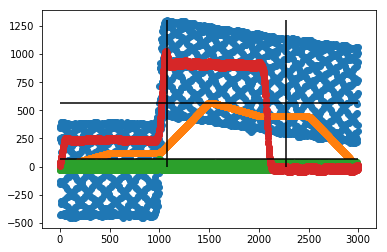

In [21]:
import matplotlib.pyplot as plt

# Draw things!
plt.scatter(wfindex, wf[wfnum])
#plt.scatter(wfindex, trap[wfnum])
#plt.scatter(wfindex, curr[wfnum])
plt.scatter(wfindex, dcr_trap_norm[wfnum])
#plt.hlines(trapE[wfnum], wfindex[0], wfindex[-1])
#plt.hlines(curr_amp[wfnum], wfindex[0], wfindex[-1])
plt.vlines(dcr_trap_max_sample[wfnum], 0, np.amax(wf[wfnum]))
plt.vlines(dcr_trap_max_sample[wfnum] + 1200, 0, np.amax(wf[wfnum]))

plt.show();